In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, RidgeCV
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [37]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)

In [4]:
# dataset without hazardous dataset - this dataset is bigger
ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

In [ ]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [201]:
# capping - removing extreme outliers
#ultimate_df['COUNT'] = ultimate_df[ultimate_df['COUNT'] <= 8]

#ultimate_df['COUNT'] = np.log(ultimate_df['COUNT'])

# ultimate_df['COUNT'] = quantile_transform(
#     ultimate_df['COUNT'].to_frame(), n_quantiles=500, output_distribution="normal", copy=True
# ).squeeze()

In [ ]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [6]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [25]:
ultimate_df.shape

(921, 20)

In [5]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

In [28]:
ultimate_df.shape

(3030, 20)

In [6]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [7]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [8]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)

In [151]:
ultimate_df.columns

Index(['LATITUDE', 'LONGITUDE', 'INVAGE', 'RDSFCOND', 'VISIBILITY', 'LIGHT',
       'TRAFFCTL', 'DRIVACT', 'DRIVCOND', 'VEHTYPE', 'TIME', 'AvgAcceleration',
       'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV',
       'PercentOfVehicles', 'PercentOther', 'COUNT'],
      dtype='object')

In [9]:
#X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude')]]
# for smaller complete dataset
#X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]
# for bigger dataset
X = ultimate_df[['DRIVACT', 'DRIVCOND','TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles']]
Y = ultimate_df['COUNT']
X = pd.get_dummies(X, drop_first = True)


#X = sm.add_constant(X)



In [60]:
model = sm.OLS(Y, X)
results = model.fit()

In [61]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     19.03
Date:                Thu, 03 Mar 2022   Prob (F-statistic):          8.14e-123
Time:                        20:43:22   Log-Likelihood:                -5262.4
No. Observations:                3030   AIC:                         1.061e+04
Df Residuals:                    2987   BIC:                         1.087e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         2.0971      1.004      2.088      0.037       0.128       4.066
AvgAcceleration                               0.1694      0.151      1.119      0.263      -0.127       0.466
PercentOfVehicles                            -0.0802      0.654     -0.123      0.902      -1.363       1.202
DRIVACT_Disobeyed Traffic Control            -1.3946      0.631     -2.211      0.027      -2.632      -0.158
DRIVACT_Failed to Yield Right of Way         -1.5999      0.627     -2.551      0.011      -2.829      -0.370
DRIVACT_Following too Close                  -1.6363      0.630     -2.596      0.009      -2.872      -0.400
DRIVACT_Improper Lane Change                 -1.6487      0.647     -2.548      0.011      -2.918      -0.380
DRIVACT_Improper Passing                     -1.5665      0.655     -2.390      0.017      -2.851      -0.281
DRIVACT_Improper Turn                        -1.5279      0.630     -2.425      0.015      -2.763      -0.293
DRIVACT_Lost control                         -1.7648      0.627     -2.814      0.005      -2.995      -0.535
DRIVACT_Other                                -1.6913      0.630     -2.685      0.007      -2.927      -0.456
DRIVACT_Speed too Fast For Condition         -1.7542      0.638     -2.751      0.006      -3.005      -0.504
DRIVACT_Speed too Slow                       -1.7842      1.163     -1.534      0.125      -4.064       0.496
DRIVACT_Speeding                             -1.6179      0.636     -2.545      0.011      -2.865      -0.371
DRIVACT_Wrong Way on One Way Road            -2.4750      0.932     -2.655      0.008      -4.303      -0.647
DRIVCOND_Ability Impaired (Drugs/Alcohol)     1.3891      0.638      2.176      0.030       0.137       2.641
DRIVCOND_Fatigue                              1.2574      0.688      1.828      0.068      -0.092       2.606
DRIVCOND_Inattentive                          1.4371      0.642      2.240      0.025       0.179       2.695
DRIVCOND_Medical or Physical Disability       1.7635      0.652      2.703      0.007       0.484       3.043
DRIVCOND_Normal                               1.4328      0.641      2.236      0.025       0.176       2.689
DRIVCOND_Other                                1.5851      0.698      2.272      0.023       0.217       2.953
DRIVCOND_Unknown                              1.5384      0.641      2.400      0.016       0.281       2.795
TRAFFCTL_Controller present                   0.4485      0.845      0.531      0.596      -1.208       2.105
TRAFFCTL_No Control                          -0.7837      0.796     -0.985      0.325      -2.344       0.776
TRAFFCTL_Pedestrian Crossover                -0.9871      0.826     -1.194      0.232      -2.608       0.633
TRA

<AxesSubplot:xlabel='COUNT'>

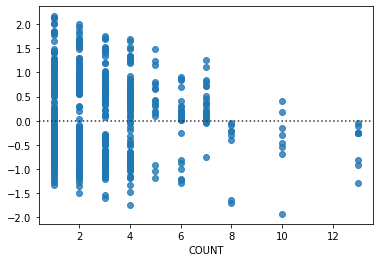

In [24]:
sns.residplot(y = results.predict(X), x = Y)

In [10]:
regressionSummary(Y, results.predict(X))

NameError: name 'results' is not defined

In [ ]:
#results.params.reset_index().rename(columns = {'index': 'Variables', '0': 'Coefficients'})

In [15]:
#X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'VEHTYPE', 'INVAGE')]]
# X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]

# X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [16]:
X.shape

(706, 44)

In [11]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [12]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : -0.0300
       Root Mean Squared Error (RMSE) : 1.4807
            Mean Absolute Error (MAE) : 1.1277
          Mean Percentage Error (MPE) : -44.3746
Mean Absolute Percentage Error (MAPE) : 68.6258


In [13]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_Y)

LinearRegression()

In [14]:
print(regressionSummary(train_Y, linear_model.predict(train_X)))
regressionSummary(valid_Y, linear_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.3859
            Mean Absolute Error (MAE) : 1.0127
          Mean Percentage Error (MPE) : -33.3989
Mean Absolute Percentage Error (MAPE) : 57.4912
None

Regression statistics

                      Mean Error (ME) : -0.0325
       Root Mean Squared Error (RMSE) : 1.3395
            Mean Absolute Error (MAE) : 0.9889
          Mean Percentage Error (MPE) : -33.3973
Mean Absolute Percentage Error (MAPE) : 57.4172


Estimating transforms: 100%|██████████| 1000/1000 [00:03<00:00, 323.34it/s]


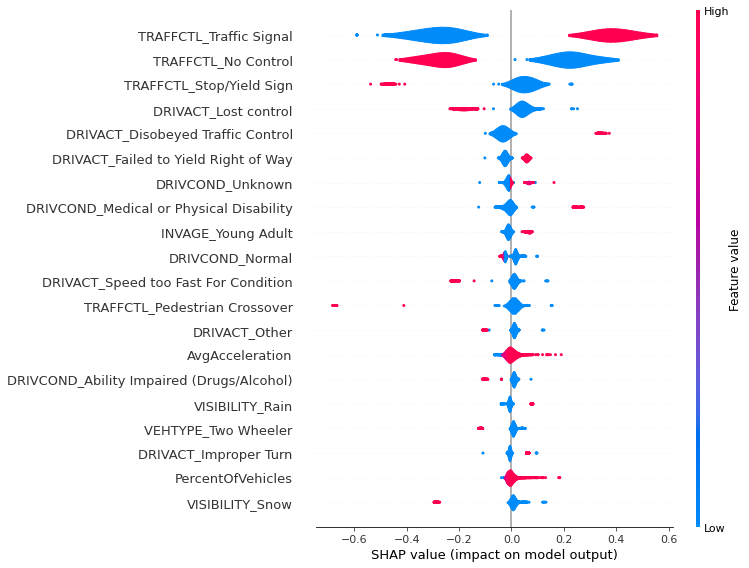

In [15]:
explainer = shap.Explainer(linear_model, masker=shap.maskers.Impute(data= X),
                           feature_names= X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type = 'violin')

In [22]:
pd.DataFrame({'Actual': valid_Y, 'Predicted': linear_model.predict(valid_X)})

,Actual,Predicted
605,1,2.919491
425,2,3.627372
334,1,2.210006
457,4,3.600056
187,1,1.024437
...,...,...
119,4,3.859712
82,6,3.828721
615,4,2.878520
311,3,1.302319


<AxesSubplot:xlabel='COUNT'>

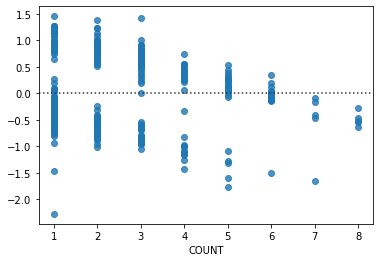

In [68]:
sns.residplot(y = linear_model.predict(valid_X), x = valid_Y)

In [69]:
pd.DataFrame({'Feature': train_X.columns, 'coefficients': linear_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
17,DRIVCOND_Medical or Physical Disability,1.971175
19,DRIVCOND_Other,1.787897
20,DRIVCOND_Unknown,1.712872
14,DRIVCOND_Ability Impaired (Drugs/Alcohol),1.526826
16,DRIVCOND_Inattentive,1.512426
18,DRIVCOND_Normal,1.477186
15,DRIVCOND_Fatigue,1.311871
21,TRAFFCTL_Controller present,0.775210
37,VISIBILITY_Freezing Rain,0.753105
25,TRAFFCTL_Traffic Signal,0.685132


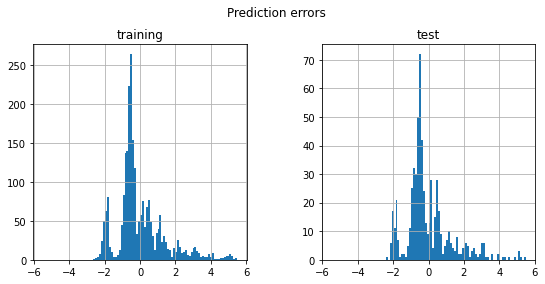

In [70]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - linear_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - linear_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#fig.text(0.5, 0.05, 'Skew: ' + str(pred_error_train.skew()), ha = 'center')
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [71]:
pred_error_train.skew()

residual    1.385782
dtype: float64

In [72]:
pred_error_test.skew()

residual    1.328044
dtype: float64

In [38]:
r2_score(valid_Y, linear_model.predict(valid_X))

0.11091770962826886

In [16]:
# these functions assume the existence of a train_Y 
def train_model(variables): 
    if len(variables) == 0: 
        return None 
    model = LinearRegression() 
    model.fit(train_X[variables], train_Y) 
    return model 
    
def score_model(model, variables): 
    if len(variables) == 0: 
        return AIC_score(train_Y, [train_Y.mean()] * len(train_Y), model, df=1) 
    return AIC_score(train_Y, model.predict(train_X[variables]), model) 

In [17]:
forwards_model, best_variables_forward = forward_selection(train_X.columns, train_model, score_model, verbose = True)

Variables: AvgAcceleration, PercentOfVehicles, DRIVACT_Disobeyed Traffic Control, DRIVACT_Failed to Yield Right of Way, DRIVACT_Following too Close, DRIVACT_Improper Lane Change, DRIVACT_Improper Passing, DRIVACT_Improper Turn, DRIVACT_Lost control, DRIVACT_Other, DRIVACT_Speed too Fast For Condition, DRIVACT_Speed too Slow, DRIVACT_Speeding, DRIVACT_Wrong Way on One Way Road, DRIVCOND_Ability Impaired (Drugs/Alcohol), DRIVCOND_Fatigue, DRIVCOND_Inattentive, DRIVCOND_Medical or Physical Disability, DRIVCOND_Normal, DRIVCOND_Other, DRIVCOND_Unknown, TRAFFCTL_Controller present, TRAFFCTL_No Control, TRAFFCTL_Pedestrian Crossover, TRAFFCTL_Stop/Yield Sign, TRAFFCTL_Traffic Signal, INVAGE_Children, INVAGE_Senior, INVAGE_Super Senior, INVAGE_Young Adult, VEHTYPE_Medium-size Vehicle, VEHTYPE_Other, VEHTYPE_Small-size Vehicle, VEHTYPE_Two Wheeler, VISIBILITY_Clear, VISIBILITY_Drifting Snow, VISIBILITY_Fog, Mist, Smoke, Dust, VISIBILITY_Freezing Rain, VISIBILITY_Other, VISIBILITY_Rain, VISIBIL

In [18]:
print(regressionSummary(train_Y, forwards_model.predict(train_X[best_variables_forward])))
regressionSummary(valid_Y, forwards_model.predict(valid_X[best_variables_forward]))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.3914
            Mean Absolute Error (MAE) : 1.0200
          Mean Percentage Error (MPE) : -33.6916
Mean Absolute Percentage Error (MAPE) : 57.8530
None

Regression statistics

                      Mean Error (ME) : -0.0455
       Root Mean Squared Error (RMSE) : 1.3406
            Mean Absolute Error (MAE) : 0.9895
          Mean Percentage Error (MPE) : -34.6224
Mean Absolute Percentage Error (MAPE) : 57.6319


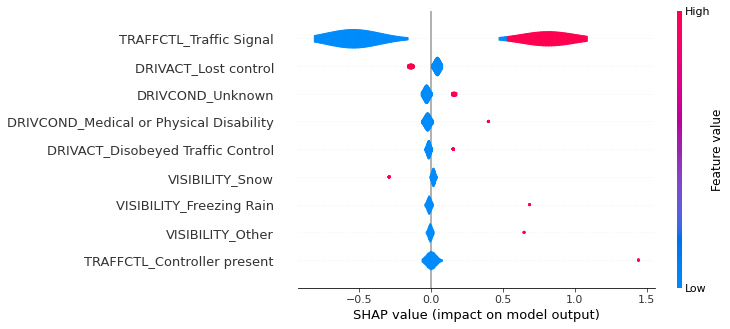

In [19]:
masker = shap.maskers.Independent(data= X[best_variables_forward])
explainer = shap.Explainer(forwards_model, masker= masker,
                           feature_names= valid_X[best_variables_forward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_forward])
shap.summary_plot(shap_values, valid_X[best_variables_forward], plot_type = 'violin')

In [19]:
pd.DataFrame({'Feature': best_variables_forward, 'coefficients': forwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
1,TRAFFCTL_Controller present,1.442174
0,TRAFFCTL_Traffic Signal,1.354114
8,VISIBILITY_Freezing Rain,0.699923
7,VISIBILITY_Other,0.654248
3,DRIVCOND_Medical or Physical Disability,0.425919
2,DRIVCOND_Unknown,0.190974
5,DRIVACT_Disobeyed Traffic Control,0.173310
4,DRIVACT_Lost control,-0.183744
6,VISIBILITY_Snow,-0.304348


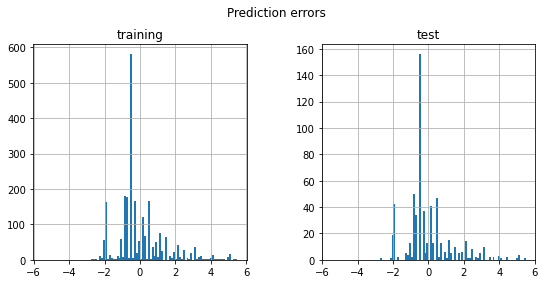

In [20]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - forwards_model.predict(train_X[best_variables_forward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - forwards_model.predict(valid_X[best_variables_forward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [21]:
pred_error_train.skew()

residual    1.389508
dtype: float64

In [22]:
pred_error_test.skew()

residual    1.338226
dtype: float64

<AxesSubplot:xlabel='COUNT'>

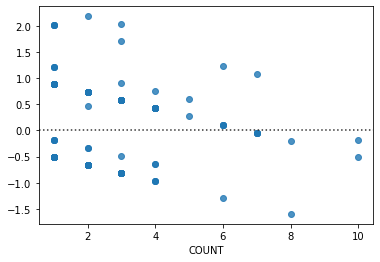

In [24]:
sns.residplot(y = forwards_model.predict(valid_X[best_variables_forward]), x = valid_Y)

In [21]:
backwards_model, best_variables_backward = backward_elimination(train_X.columns, train_model, score_model, verbose = False)

In [22]:
print(regressionSummary(train_Y, backwards_model.predict(train_X[best_variables_backward])))
regressionSummary(valid_Y, backwards_model.predict(valid_X[best_variables_backward]))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.3874
            Mean Absolute Error (MAE) : 1.0144
          Mean Percentage Error (MPE) : -33.4452
Mean Absolute Percentage Error (MAPE) : 57.5403
None

Regression statistics

                      Mean Error (ME) : -0.0352
       Root Mean Squared Error (RMSE) : 1.3397
            Mean Absolute Error (MAE) : 0.9889
          Mean Percentage Error (MPE) : -33.6665
Mean Absolute Percentage Error (MAPE) : 57.5381


In [25]:
pd.DataFrame({'Feature': best_variables_backward, 'coefficients': backwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
15,DRIVCOND_Medical or Physical Disability,2.015323
17,DRIVCOND_Other,1.842972
18,DRIVCOND_Unknown,1.761366
12,DRIVCOND_Ability Impaired (Drugs/Alcohol),1.586314
14,DRIVCOND_Inattentive,1.561216
16,DRIVCOND_Normal,1.526615
13,DRIVCOND_Fatigue,1.389964
23,VISIBILITY_Freezing Rain,0.718152
22,INVAGE_Young Adult,0.116414
24,VISIBILITY_Snow,-0.274221


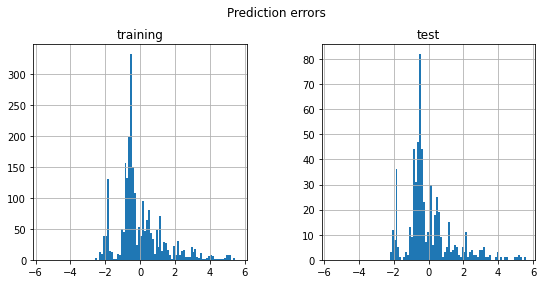

In [26]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - backwards_model.predict(train_X[best_variables_backward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - backwards_model.predict(valid_X[best_variables_backward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [30]:
pred_error_train.skew()

residual    2.033159
dtype: float64

In [31]:
pred_error_test.skew()

residual    1.302312
dtype: float64

<AxesSubplot:xlabel='COUNT'>

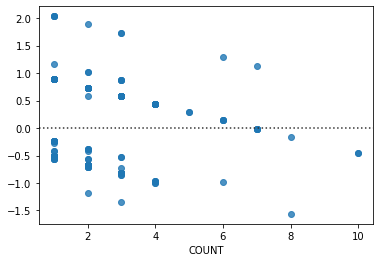

In [32]:
sns.residplot(y = backwards_model.predict(valid_X[best_variables_backward]), x = valid_Y)

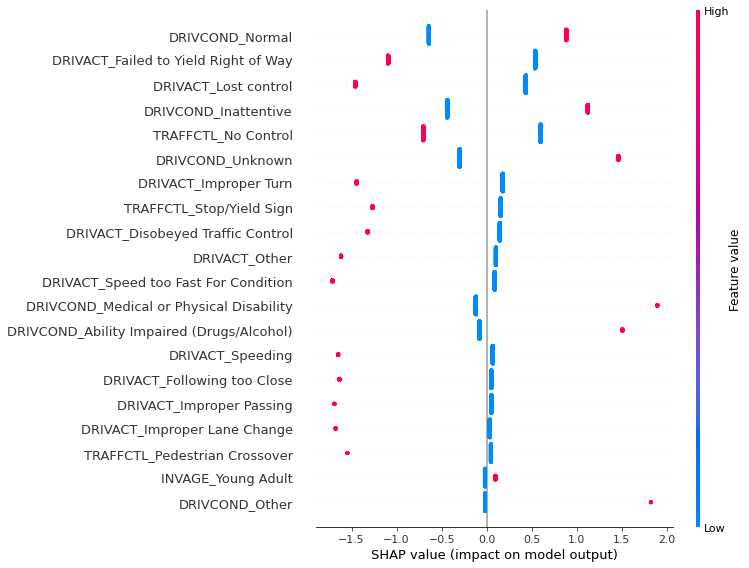

In [23]:
masker = shap.maskers.Independent(data= X[best_variables_backward])
explainer = shap.Explainer(backwards_model, masker= masker,
                           feature_names= valid_X[best_variables_backward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_backward])
shap.summary_plot(shap_values, valid_X[best_variables_backward])

In [127]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude')]]
# for smaller complete dataset
#X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]
# for bigger dataset
X = pd.get_dummies(X, drop_first = True)

#X = sm.add_constant(X)

Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [128]:
ridge_model = RidgeCV()
ridge_model.fit(train_X, train_Y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [129]:
print(regressionSummary(train_Y, ridge_model.predict(train_X)))
regressionSummary(valid_Y, ridge_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1.7527
            Mean Absolute Error (MAE) : 1.3597
          Mean Percentage Error (MPE) : -43.0487
Mean Absolute Percentage Error (MAPE) : 68.1889
None

Regression statistics

                      Mean Error (ME) : 0.0408
       Root Mean Squared Error (RMSE) : 2.1193
            Mean Absolute Error (MAE) : 1.6427
          Mean Percentage Error (MPE) : -50.1937
Mean Absolute Percentage Error (MAPE) : 80.2193


<AxesSubplot:xlabel='COUNT'>

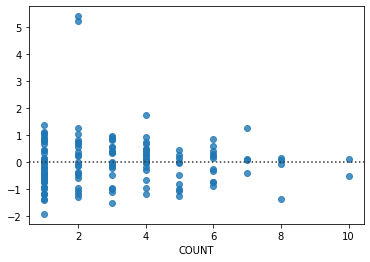

In [130]:
sns.residplot(y = ridge_model.predict(valid_X), x = valid_Y)

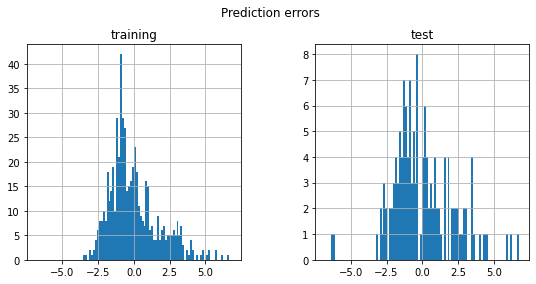

In [131]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - ridge_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - ridge_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [132]:
pred_error_train.skew()

residual    1.04578
dtype: float64

In [133]:
pred_error_test.skew()

residual    0.499259
dtype: float64

In [135]:
pd.DataFrame({'Feature': X.columns, 'coefficients': ridge_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
45,TRAFFCTL_Traffic Signal,0.928779
60,"DRIVCOND_Ability Impaired, Drugs",0.731386
73,VEHTYPE_Municipal Transit Bus (TTC),0.652432
47,DRIVACT_Disobeyed Traffic Control,0.638186
39,LIGHT_Dusk,0.522550
...,...,...
68,"VEHTYPE_Automobile, Station Wagon",-0.353282
72,VEHTYPE_Motorcycle,-0.440388
56,DRIVACT_Speed too Fast For Condition,-0.477026
18,INVAGE_80 to 84,-0.555840


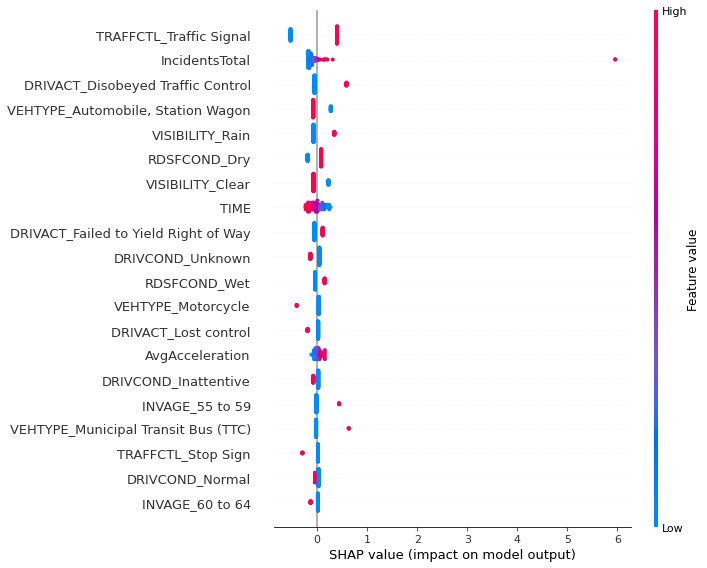

In [142]:
masker = shap.maskers.Independent(data= valid_X)
explainer = shap.Explainer(ridge_model, masker= masker,
                           feature_names= valid_X.columns, algorithm="auto")
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)